In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=0fe39fc555d6ee6d20b3bcb36d98099f98c06285070f2680c8d3904b2b773cd3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, lit
import numpy as np

In [ ]:
conf = SparkConf().setAppName("PageRank").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [ ]:
spark = SparkSession.builder.appName("PageRank").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Lógica y Representación III/web-BerkStan.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = sc.textFile(file_path, 4)
data = data.filter(lambda line: not line.startswith("#"))

## Solución PageRank en SPARK usando RDD's

In [ ]:
def parseLine(line):
    node, outgoing_edge = line.split()
    return (node, outgoing_edge)

graph = data.map(parseLine)
graph = graph.groupByKey()

num_nodes = graph.flatMap(lambda x: [x[0], *x[1]]).distinct().count()
pagerank = graph.map(lambda x: (x[0], 1/num_nodes))
num_iterations = 70
beta = 0.8

for _ in range(num_iterations):
  pivot = graph.join(pagerank)
  contributions = pivot.flatMap(lambda x: [(destino, beta * x[1][1] / len(x[1][0])) for destino in x[1][0]])
  pagerank = contributions.groupByKey().map(lambda x: (x[0], sum(x[1]) + (1 - beta) / num_nodes))

In [ ]:
final_pagerank = np.array(pagerank.take(10))
for node, rank in final_pagerank:
    print(f"Nodo {node}: PageRank = {rank}")

## Solución PageRank en SPARK usando DataFrames

In [ ]:
from pyspark import Row
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import col, size, lit, sum
from pyspark.sql.functions import explode

web = data.map(lambda s: s.split()).map(lambda p: Row(node=p[0], dest=p[1]))
dfWeb = spark.createDataFrame(web)
dfGroupWeb = dfWeb.groupBy("node").agg(collect_list("dest").alias("destinations"))

num_nodes = dfWeb.select("node").distinct().count()
pagerank = dfWeb.select("node").distinct().withColumn("page_rank", lit(1/num_nodes))
num_iterations = 20
beta = 0.8
dfWeb = dfWeb.withColumnRenamed("node", "df_node")
dfGroupWeb = dfGroupWeb.withColumnRenamed("node", "df_group_node")
pagerank = pagerank.withColumnRenamed("node", "pr_node")

for _ in range(num_iterations):
  contributions = dfWeb.join(dfGroupWeb, dfWeb.df_node == dfGroupWeb.df_group_node, "inner").join(pagerank, dfWeb.df_node == pagerank.pr_node, "inner").select(
      dfWeb.dest.alias("node"),
      (beta * col("page_rank") / size(col("destinations"))).alias("contribution")
  )
  pagerank = contributions.groupBy("node").agg((sum("contribution") + (1 - beta) / num_nodes).alias("page_rank"))
  pagerank = pagerank.withColumnRenamed("node", "pr_node")

In [ ]:
pagerank.show()

+-------+--------------------+
|pr_node|           page_rank|
+-------+--------------------+
|   9993|6.657218952635212E-7|
|  82775|4.401839893276228E-7|
| 101122|1.124012926406492...|
| 100704| 1.91951277749695E-6|
|  78888|3.998187071582117...|
|  80422|4.355281652750173...|
| 100735|1.231430960646626...|
|  66401|1.284930125580388...|
|  66584|1.589296020902577...|
|  66616|1.633120914450299...|
|  85022|4.002595899606624...|
| 101021|1.027062721946819...|
| 100010|9.071895995508967E-7|
|  82971|4.088747945121650...|
|  95519|1.645721248439157...|
| 100140|1.147157516032109E-6|
| 100227|1.288275500920456...|
|  95134|1.304872429897337E-6|
|  77814|5.194423573063446E-7|
|  77930|5.217344595664166E-7|
+-------+--------------------+
only showing top 20 rows



In [ ]:
sc.stop()

# PageRank Solución Anterior

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms.shortest_paths.unweighted import predecessor
from networkx.utils.misc import nodes_equal
import networkx as nx
import pandas as pd

class WebMatrix:
    _df_matrix = pd.DataFrame(columns=['degree','dest'])
    def __init__(self, nodes, edges):
      self._G = nx.DiGraph()
      self.add_nodes(nodes)
      self.add_edges(edges)

    def add_nodes(self, nodes):
      self._G.add_nodes_from(nodes)
      self._nodes = self._G.number_of_nodes()

    def add_edges(self, edges):
      self._G.add_edges_from(edges)
      self._edges =  self._G.number_of_edges()

    def remove_node(self, node):
      self._G.remove_node(node)

    def get_nodes(self):
      return list(self._G.nodes)

    def build_matrix(self):
      nodes = self.get_nodes()
      degrees = [0 for _ in range(0, len(nodes))]
      dest = [[] for _ in range(0, len(nodes))]
      for i in range(0, len(nodes)):
        degree = self._G.out_degree(nodes[i])
        degrees[i] = degree
        dest[i] = (list(self._G.successors(nodes[i])))
      df_matrix = pd.DataFrame({'degree': degrees, 'dest': dest}, index = nodes)
      self._df_matrix = df_matrix.loc[df_matrix['degree'] != 0]
      return self._df_matrix

    def view(self):
      nx.draw(self._G, with_labels=True, font_color='white', node_color="purple", edgecolors="blue", font_size=8,  node_size= 900, font_weight="bold")

    def find_dead_ends(self):
      dead_ends = []
      nodes = list(self._G.nodes())
      for node in nodes:
          degree = self._G.out_degree(node)
          if degree == 0:
            predecessors = list(self._G.predecessors(node))
            dead_ends.append([node, predecessors])
      return dead_ends

In [ ]:
from numpy import False_
from matplotlib.lines import VertexSelector
from pandas._libs.tslibs import vectorized
import copy

class PageRank:
    page_rank = None
    _web_matrix_without_dead_ends = None
    _dead_ends = None
    def __init__(self, web_matrix, beta):
      self._web_matrix = web_matrix
      self.get_page_rank(beta)

    def drop_dead_ends(self):
      if self._dead_ends == None:
        self._dead_ends = []
        self._web_matrix_without_dead_ends = copy.deepcopy(self._web_matrix)
        pivot = True
        while pivot:
          dead_ends = self._web_matrix_without_dead_ends.find_dead_ends()
          if dead_ends:
            for dead_end in dead_ends:
              self._dead_ends.append(dead_end)
              self._web_matrix_without_dead_ends.remove_node(dead_end[0])
          else:
            pivot = False
      return self._dead_ends

    def create_page_rank(self):
      page_rank = {}
      nodes = self._web_matrix.get_nodes()
      for node in nodes:
        page_rank[node] = 0
      return page_rank

    def get_page_rank(self, beta):
      if self.page_rank == None:
        self.page_rank = self.create_page_rank()
      self.drop_dead_ends()
      V = self.taxation(beta)
      M = self._web_matrix_without_dead_ends.build_matrix()
      i = 0
      for row in M.itertuples():
        self.page_rank[row.Index] += V[i]
        i += 1
      self.compute_page_rank()
      return self.page_rank

    def taxation(self, beta, S=None):
      M = self._web_matrix_without_dead_ends.build_matrix()
      n = len(self._web_matrix_without_dead_ends.get_nodes())
      V = self.get_V0(S)
      e = self.get_V0(S)
      pivot = True
      while(pivot):
        Vpost = self.get_V(M, V, beta, e)
        if self.evaluate_condition(V, Vpost, 1e-8):
          pivot = False
        V = Vpost
      return Vpost

    def get_V0(self, S):
      nodes = self._web_matrix_without_dead_ends.get_nodes()
      n = len(self._web_matrix_without_dead_ends.get_nodes())
      if S == None:
        return [1/n]*n
      else:
        v = [0]*n
        size = len(S)
        for node in S:
          index = nodes.index(node)
          v[index] = 1/size
        return v

    def get_V(self, M, V, beta, e):
      Vpost = self.M_dot_V(M, V)
      for x in range(0, len(Vpost)):
        Vpost[x] = beta*Vpost[x] + (1-beta)*e[x]
      return Vpost

    def M_dot_V(self, M, V):
      n = len(V)
      Vpost = [0]*n
      for row in M.itertuples():
            x = 1/row.degree
            index =  M.index.get_loc(row.Index)
            y = V[index]
            value = x*y
            for node in row.dest:
              i = M.index.get_loc(node)
              Vpost[i] += value
      return Vpost

    def compute_page_rank(self):
      M = self._web_matrix.build_matrix();
      i = len(self._dead_ends) - 1
      while i > -1:
        node = self._dead_ends[i][0]
        predecesors = self._dead_ends[i][1]
        for predecesor in predecesors:
          index = M.index.get_loc(predecesor)
          prob = 1/M.iloc[index].degree
          self.page_rank[node] += prob*self.page_rank[predecesor]
        i -= 1
      return self.page_rank

    def evaluate_condition(self, v1, v2, err):
      isClosed = True
      i=0
      while (i < len(v1)) :
        if abs(v1[i]-v2[i]) > err:
          i = len(v1)
          isClosed = False
        i+=1
      return isClosed

    def mass_spam(self, S):
      beta = 0.8
      alpha = 0.1
      nodes = self._web_matrix.get_nodes()
      pageRanks = []
      backwardings = []
      trustRanks = []
      spamMass = []
      trust_rank = self.trust_rank(beta, S)
      backwarding = self.get_page_rank_with_backwarding(beta, alpha)
      mass_spam = {}
      for page in self.page_rank:
        mass_spam[page] = (self.page_rank[page] - trust_rank[page]) / self.page_rank[page]
        pageRanks.append(self.page_rank[page])
        backwardings.append(backwarding[page])
        trustRanks.append(trust_rank[page])
        spamMass.append(mass_spam[page])
      calcSpamMass = pd.DataFrame({'Node': nodes, 'PageRank': pageRanks, 'Backwarding': backwardings, 'TrustRank': trustRanks, 'MassSpam': spamMass})
      return calcSpamMass

    def trust_rank(self, beta, S):
      tr = self.create_page_rank()
      Vpost = self.taxation(beta, S)
      M = self._web_matrix_without_dead_ends.build_matrix()
      i = 0
      for row in M.itertuples():
        tr[row.Index] += Vpost[i]
        i += 1
      return tr

    def get_page_rank_with_backwarding(self, beta, alpha):
      bw = self.create_page_rank()
      M = self._web_matrix_without_dead_ends.build_matrix()
      Vpost = self.backwarding(beta, alpha)
      i = 0
      for row in M.itertuples():
        bw[row.Index] += Vpost[i]
        i += 1
      return bw

    def backwarding(self, beta, alpha, S=None):
      M = self._web_matrix_without_dead_ends.build_matrix()
      n = len(self._web_matrix_without_dead_ends.get_nodes())
      V = self.get_V0(S)
      e = self.get_V0(S)
      Vant = list(V)
      results = []
      i = 0
      pivot = True
      while(pivot):
        Vbefore = results[i - 1] if i > 0 else [0]*n
        Vpost = self.get_V_backwarding(M, V, Vant, beta, alpha, e)
        results.append(Vpost)
        if self.evaluate_condition(V, Vpost, 1e-8):
          pivot = False
        Vant = V
        V = Vpost
        i += 1
      return Vpost

    def get_V_backwarding(self, M, V, Vant, beta, alpha, e):
      Vpost1 = self.M_dot_V(M, V)
      Vpost2 = self.M_dot_V(M, Vant)
      for x in range(0, len(Vpost1)):
        Vpost1[x] = beta*Vpost1[x] + alpha*Vpost2[x] + (1-beta-alpha)*e[x]
      return Vpost1

In [ ]:
import random
from matplotlib.pyplot import figure

num_nodes = int(input("Ingrese la cantidad de nodos que desea crear: "))
nodes = [f"page-{i}" for i in range(1, num_nodes + 1)]
edges = []
max_outgoing_connections = 5
probability_single_edge = 0.8
while True:
  node1, node2 = random.sample(nodes, 2)
  outgoing_connections = sum(1 for edge in edges if edge[0] == node1)
  if outgoing_connections < max_outgoing_connections:
    if outgoing_connections == 0 and random.random() > probability_single_edge:
      continue
    edges.append((node1, node2))
  random_limit = random.randint(num_nodes * 2, num_nodes * max_outgoing_connections * 2)
  if len(edges) >= random_limit:
      break

Web = WebMatrix(nodes, edges)
df = Web.build_matrix()
print(" ")
print("Web Matrix: ")
df

Ingrese la cantidad de nodos que desea crear: 10
 
Web Matrix: 


,degree,dest
page-1,2,"[page-3, page-9]"
page-2,3,"[page-9, page-5, page-3]"
page-3,4,"[page-7, page-4, page-5, page-6]"
page-5,2,"[page-1, page-8]"
page-6,4,"[page-9, page-10, page-5, page-4]"
page-7,3,"[page-8, page-2, page-9]"
page-8,5,"[page-4, page-7, page-1, page-5, page-9]"
page-9,3,"[page-2, page-8, page-5]"


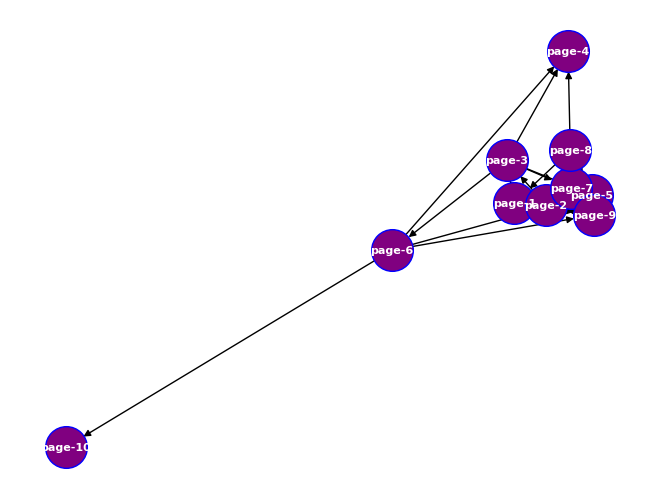

In [ ]:
Web.view()

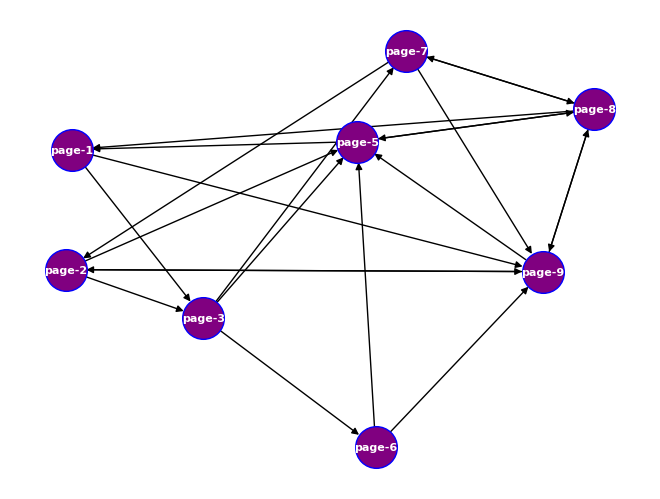

In [ ]:
beta = 0.8
page_rank = PageRank(Web, beta)
page_rank._web_matrix_without_dead_ends.view()

In [ ]:
page_rank.page_rank

{'page-1': 0.13119162324216402,
 'page-2': 0.09623055195300292,
 'page-3': 0.10313812879436722,
 'page-4': 0.0726474370920451,
 'page-5': 0.18113648554403883,
 'page-6': 0.052503501697009354,
 'page-7': 0.0862405295461715,
 'page-8': 0.16868514734600482,
 'page-9': 0.18087403187724127,
 'page-10': 0.013125875424252339}

In [ ]:
page_rank.mass_spam(["page-7","page-1"])

,Node,PageRank,Backwarding,TrustRank,MassSpam
0,page-1,0.131192,0.135295,0.182378,-0.390166
1,page-2,0.096231,0.092658,0.088101,0.084479
2,page-3,0.103138,0.101180,0.096445,0.064896
3,page-4,0.072647,0.000000,0.000000,1.000000
4,page-5,0.181136,0.184939,0.134912,0.255190
5,page-6,0.052504,0.042854,0.025719,0.510154
6,page-7,0.086241,0.082427,0.154132,-0.787232
7,page-8,0.168685,0.175880,0.142066,0.157804
8,page-9,0.180874,0.184766,0.176247,0.025580
9,page-10,0.013126,0.000000,0.000000,1.000000


In [ ]:
business_nodes = ["page-1","page-2","page-3","page-4", "page-5"]
business_edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-4","page-2"),("page-4","page-3"), ("page-3","page-5") ]
web = WebMatrix(business_nodes, business_edges)
page_rank = PageRank(web, 1)
print("Negocios")
print(page_rank.mass_spam(["page-2","page-4" ]))

Negocios
     Node  PageRank  Backwarding  TrustRank  MassSpam
0  page-1  0.222222     0.229885   0.183673  0.173469
1  page-2  0.444444     0.436782   0.459184 -0.033163
2  page-3  0.240741     0.000000   0.000000  1.000000
3  page-4  0.333333     0.333333   0.357143 -0.071429
4  page-5  0.240741     0.000000   0.000000  1.000000


In [ ]:
sport_nodes = ["page-1","page-2","page-3","page-4"]
sport_edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-3","page-1"),("page-4","page-3"),("page-4","page-2")]
web = WebMatrix(sport_nodes, sport_edges)
page_rank = PageRank(web, 1)
print("Deportes")
print(page_rank.mass_spam(["page-2","page-1" ]))

Deportes
     Node  PageRank  Backwarding  TrustRank  MassSpam
0  page-1  0.333333     0.327586   0.348980 -0.046939
1  page-2  0.222222     0.224138   0.274150 -0.233673
2  page-3  0.222222     0.224138   0.174150  0.216327
3  page-4  0.222222     0.224138   0.202721  0.087755
